# **Retail Product Categorisation**
This notebook gives an introduction to the data and a first baseline solution.

## Importing the necessary libraries

In [1]:
!pip install keras_metrics

In [2]:
from tensorflow.keras.layers import Input
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from tensorflow.keras.applications.mobilenet import MobileNet
from nltk.tokenize import word_tokenize
import gensim
import pandas as pd
from nltk.corpus import stopwords
stop_english=set(stopwords.words('english'))
from gensim.models.wrappers import FastText
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
#import cv2
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.compat.v1.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_metrics
from keras.preprocessing.image import load_img, img_to_array
%matplotlib inline

## List of classes

In [3]:
CATEGORIES = ['Electronics', 'Sports & Outdoors',
       'Cell Phones & Accessories', 'Automotive', 'Toys & Games',
       'Tools & Home Improvement', 'Health & Personal Care', 'Beauty',
       'Grocery & Gourmet Food', 'Office Products',
       'Arts, Crafts & Sewing', 'Pet Supplies', 'Patio, Lawn & Garden',
       'Clothing, Shoes & Jewelry', 'Baby',
       'Musical Instruments', 'Industrial & Scientific', 'Baby Products',
       'Appliances', 'All Beauty', 'All Electronics']

## Read the train.csv file 

In [4]:
data = pd.read_csv('../input/retail-products-classification/train.csv')
#pid = list(data['ImgId'])
#descriptions = list(data['description'])
data.head()

,ImgId,title,description,categories
0,B000HYL1V6,TUNGSTEN SOLDER PICK WITH HANDLE,Solder Pick for picking up molten solder when ...,"Arts, Crafts & Sewing"
1,B00006HXWY,Write Right 98167 Screen Protector for Sony T615C,We all screen. And we all need to protect thos...,Cell Phones & Accessories
2,B000GAWSBS,Casio Mens DBC310-1 Databank 300 Digital Watch...,"Bringing you precision at a glance, the Casio ...","Clothing, Shoes & Jewelry"
3,B000040JOL,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Tools & Home Improvement
4,B00006IB78,Energizer 2 in 1 Light,This twoway light features a bright flashlight...,Health & Personal Care


## Distribution of samples in each categories

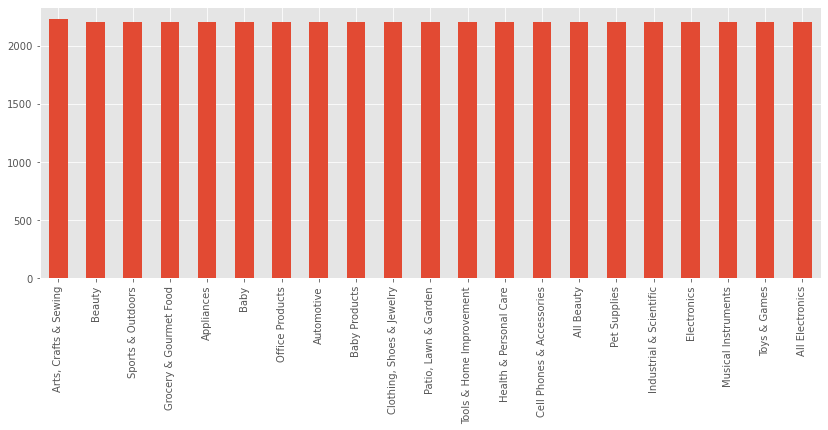

In [5]:
data['categories'].value_counts().plot(kind='bar', figsize=(14, 5));

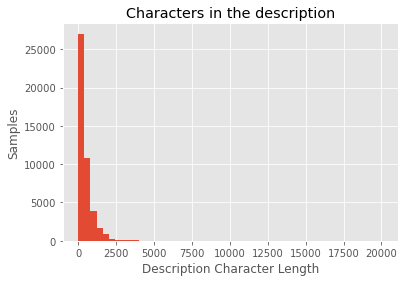

In [6]:
word_len=data['description'].str.len()
plt.hist(word_len, bins=50)
plt.ylabel('Samples')
plt.xlabel('Description Character Length')
plt.title('Characters in the description')
plt.show()

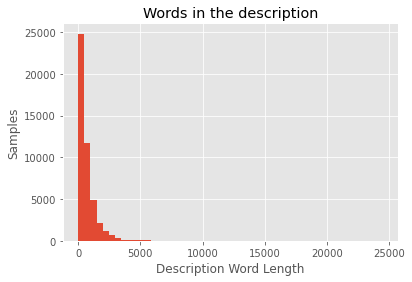

In [7]:
word_len=data['description'].str.split().map(lambda x: len(str(x)))
plt.hist(word_len, bins=50)
plt.ylabel('Samples')
plt.xlabel('Description Word Length');
plt.title('Words in the description')
plt.show()

In [8]:
train_images_path = '../input/retail-products-classification/train/train'
IMG_SIZE = (80,80)
INPUT_SHAPE = IMG_SIZE + (3,)
CALLBACK_PATIENCE = 10
BATCH_SIZE = 32
NUM_EPOCHS = 30
VALIDATION_SPLIT = .2
NUM_CLASSES = len(CATEGORIES)
L2_REGULARIZATION = 0.01

In [9]:
downloaded_files = []
for file in os.listdir(train_images_path):
    if file.endswith(".jpg"):
        downloaded_files.append(file.replace(".jpg", ""))
print(len(downloaded_files))

42000


In [10]:
def create_training_data(img):
    image = load_img(os.path.join(train_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

## Text preprocessing

In [11]:
def get_token(description):
        # split the description into tokens (words)
        tokens = set(gensim.utils.tokenize(description))
        # Avoid words does not have atleast 2 character 
        tokens = [i for i in tokens if(len(i) > 2)]
        # Remove stop words
        tokens = [s for s in tokens if s not in stop_english]
        return tokens

## Normalize the image

In [12]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    x = x - 0.5
    x = x * 2.0
    return x

## Read Data
Read all the product images from the train folder and get corresponding description from the csv file. Data should labeled by its category. 

In [13]:
corpus = []
images = []
labels = []
files = os.listdir(train_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_training_data(img)
    if img_array is not None:
        try:
            index = data[data['ImgId']==img_id].index.values[0]
            row = data.iloc[index , :]
            family = row[3]
            if family in CATEGORIES:
                description = row[2]
                title = row[1]
                images.append(img_array.astype('float32'))
                token_list = get_token(str(title) + ' ' + str(description))
                corpus.append(token_list)
                class_num = CATEGORIES.index(family)
                labels.append(class_num)
        except IndexError as error:
            print(error)

images = np.asarray(images)
labels = pd.get_dummies(labels).values
images = preprocess_input(images)

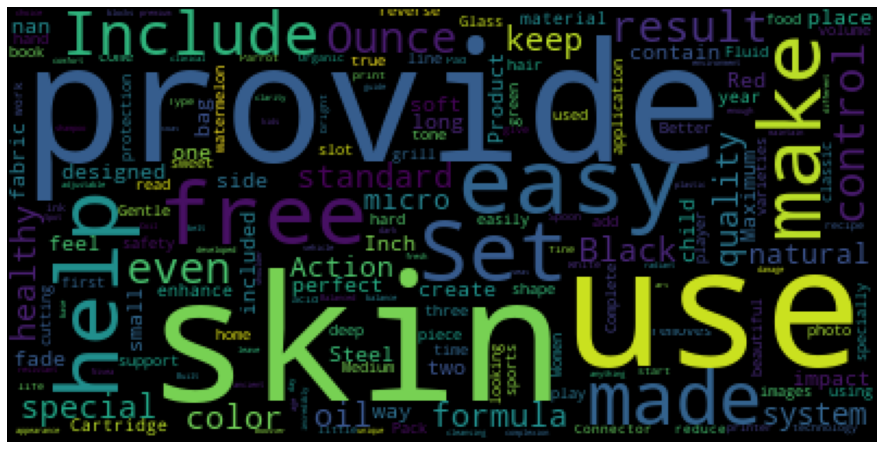

In [14]:
from wordcloud import WordCloud
plt.figure(figsize=(16,8))
text = [(" ").join(s) for s in corpus]
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(text[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [15]:
MAX_LEN=40
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

word_index=tokenizer_obj.word_index

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,300))

## FastText pretrained vectors
[Download](https://fasttext.cc/docs/en/crawl-vectors.html) and load FastText pretrained vectors. Otherwise use the gensim to load the fasttext model. These models were trained using CBOW with position-weights, in dimension 300, with character n-grams of length 5, a window of size 5 and 10 negatives. Then initilize the embedding matrix with fastText word vectors.

In [16]:
import gensim.downloader as api
model_fasttext = api.load("fasttext-wiki-news-subwords-300")
known_words = []
unknown_words = []
for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    if word in model_fasttext:
        known_words.append(word)
        embedding_matrix[i] = model_fasttext.wv[word]
    else:
        unknown_words.append(word)
        

  0%|          | 0/72350 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 72350/72350 [00:00<00:00, 127237.83it/s]


In [17]:
print(len(unknown_words))
print(len(known_words))
del model_fasttext

31996
40354


## Neural Network Model
Since our dataset contains both image and text, the model is capable to take both inputs together. For the image classification, we have used the MobileNet and LSTM network for the text classification. MobileNets are based on a streamlined architecture that uses depth-wise separable convolutions to build lightweight (17Mb) deep neural networks.
For the text classification, we have built a Keras sequential model which start with an embedding layer. The embedding layer holds individual vector for each word in the corpus. We have used fastText pre-trained English embedding to initialize each word by a 300-dimensional vector and loaded the pre-trained words embedding matrix into the embedding layer. After training the model, the words with semantically similar meaning often have similar vectors. Since the text classification model is a recurrent neural network, we added an LSTM layer followed by the embedding layer.

In [18]:
input_tensor = Input(shape=INPUT_SHAPE)
model = MobileNet(input_tensor=input_tensor, alpha=1.0,
                    include_top=False, weights=None)
output = tf.keras.layers.Reshape((4096,))(model.output)
output = tf.keras.layers.Dense(200, activation='relu')(output)
model.summary()

Model: "mobilenet_1.00_None"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 40, 40, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 40, 40, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 40, 40, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 40, 40, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 40, 40, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 40, 40, 32)

In [19]:
embedding_layer = tf.keras.layers.Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix),
                                            input_length=MAX_LEN,trainable=False)
dropout = tf.keras.layers.SpatialDropout1D(0.2)
#lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
#lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))
lstm = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)
dense = tf.keras.layers.Dense(200, activation='relu')
embedding_model = tf.keras.Sequential([
    embedding_layer,
    dropout,
    lstm,
    dense 
])
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           21705300  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 40, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               13000     
Total params: 21,811,740
Trainable params: 106,440
Non-trainable params: 21,705,300
_________________________________________________________________


## Concatenate both models
Finally, we concatenate the output of both image and text classification model for interpretation and ultimate prediction. The functional API provided by Keras will help to build complex models with multiple output/input. We have used the Keras concatenate class to merge the result of both models. It takes a list of tensors, all are of the same shape as input and returns a single tensor which is the concatenation of all inputs. The concatenated output connects to the dense layer with softmax classifier. We have used the output layer to extract the embedding.

In [20]:
merged = tf.keras.layers.Concatenate()([embedding_model.output, output])

normalize = tf.keras.layers.BatchNormalization()(merged)

final_dropout = tf.keras.layers.Dropout(0.2)(normalize)

dense_100 = tf.keras.layers.Dense(50, activation='relu')(final_dropout)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense_100)

final_model = tf.keras.Model(inputs=[model.input, embedding_model.input], outputs=output_layer)

In [21]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 40, 40, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 40, 40, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 40, 40, 32)   0           conv1_bn[0][0]                   
______________________________________________________________________________________________

tf.keras.utils.plot_model(
    final_model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

## Split the data into 80% training and 20% test

In [22]:
p = int((len(images)*80)/100)
image_train = images[:p]
image_test = images[p:]
label_train = labels[:p]
label_test = labels[p:]
text_train = tweet_pad[:p]
text_test = tweet_pad[p:]

In [23]:
print('Shape of train',image_train.shape)
print("Shape of Validation ",image_test.shape)
print('Shape of train',label_train.shape)
print("Shape of Validation ",label_test.shape)
print("Shape of Text Train ",text_train.shape)

Shape of train (33600, 80, 80, 3)
Shape of Validation  (8400, 80, 80, 3)
Shape of train (33600, 21)
Shape of Validation  (8400, 21)
Shape of Text Train  (33600, 40)


## Data Augumentation

In [24]:
from keras.preprocessing.image import ImageDataGenerator
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1, y, batch_size=BATCH_SIZE, shuffle=False)
    genX2 = gen.flow(X1, X2, batch_size=BATCH_SIZE, shuffle=False)
    i = 0
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]
            #yield X2i[1]

# Finally create generator
gen_flow = gen_flow_for_two_inputs(image_train, text_train, label_train)

In [25]:
regularization = tf.keras.regularizers.l2(L2_REGULARIZATION)

early_stop = EarlyStopping('val_loss', patience=CALLBACK_PATIENCE)
reduce_lr = ReduceLROnPlateau(
    'val_loss', factor=0.1, patience=int(CALLBACK_PATIENCE/4), verbose=1)
tensorboard = TensorBoard('./logs')
callbacks = [early_stop, reduce_lr, tensorboard]
#adam = tf.keras.optimizers.Adam(learning_rate=3e-4)
#optimizer = adam
final_model.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
              #metrics=['accuracy'])
              metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

## Train the model
During training on a supervised machine learning prediction task, the parameters of the neural network - the weights- are the embeddings will modify to minimize the loss.

In [26]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/GPU:0'):
    history = final_model.fit([image_train, text_train], label_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1, callbacks=callbacks, steps_per_epoch=len(image_train) // BATCH_SIZE, validation_data=([image_test,text_test], label_test))
except RuntimeError as e:
  print(e)

Epoch 1/30


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


1050/1050 [==============================] - 134s 119ms/step - loss: 2.5498 - accuracy: 0.2140 - precision: 0.2811 - recall: 0.0434 - val_loss: 1.7940 - val_accuracy: 0.4105 - val_precision: 0.4951 - val_recall: 0.3887
Epoch 2/30
1050/1050 [==============================] - 122s 117ms/step - loss: 1.7374 - accuracy: 0.4372 - precision: 0.5705 - recall: 0.2591 - val_loss: 1.4310 - val_accuracy: 0.5379 - val_precision: 0.6473 - val_recall: 0.2841
Epoch 3/30
1050/1050 [==============================] - 129s 123ms/step - loss: 1.5018 - accuracy: 0.5194 - precision: 0.5519 - recall: 0.3100 - val_loss: 1.3438 - val_accuracy: 0.5564 - val_precision: 0.6426 - val_recall: 0.1022
Epoch 4/30
1050/1050 [==============================] - 132s 126ms/step - loss: 1.3813 - accuracy: 0.5557 - precision: 0.6302 - recall: 0.3981 - val_loss: 1.2222 - val_accuracy: 0.6007 - val_precision: 0.6847 - val_recall: 0.3042
Epoch 5/30
1050/1050 [==============================] - 131s 125ms/step - loss: 1.2948 - ac

In [27]:
#final_model.save_weights("saved_model/weights.h5")
#final_model.load_weights("static/weights.h5")

 # **Make predictions on validation data**

In [28]:
predictions = final_model.predict([image_test,text_test],batch_size=1,verbose = 2)
classes = np.argmax(predictions, axis = 1)
y_test = np.argmax(label_test, axis = 1)

8400/8400 - 188s


In [29]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,classes)

Text(0.5, 114.0, 'Predicted label')

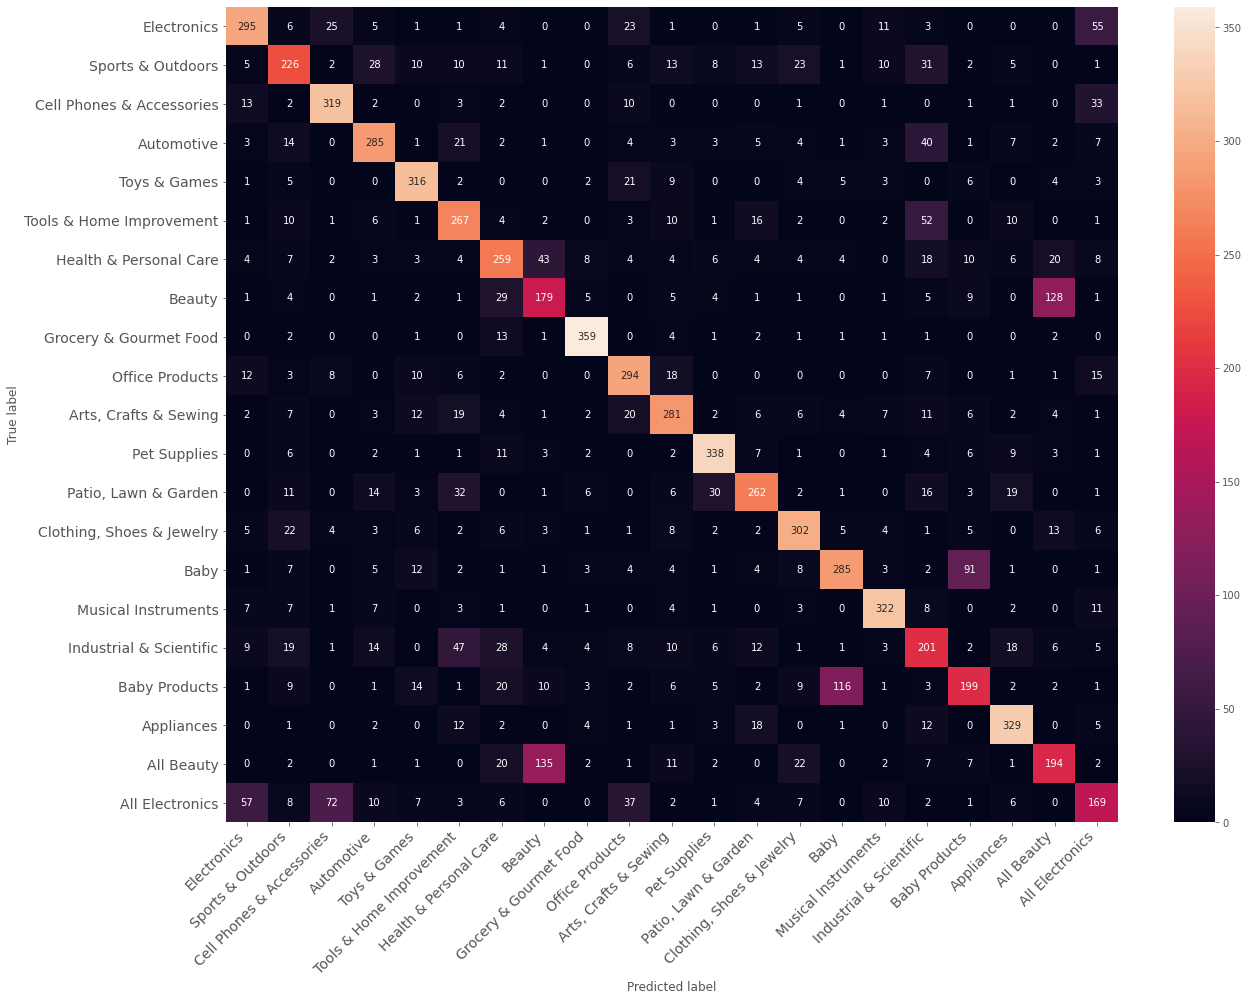

In [30]:
import seaborn as sns
df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

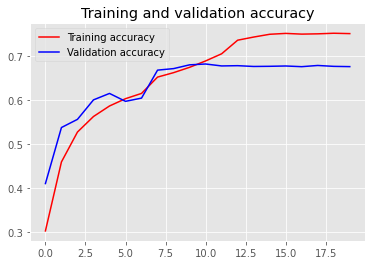

<Figure size 432x288 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

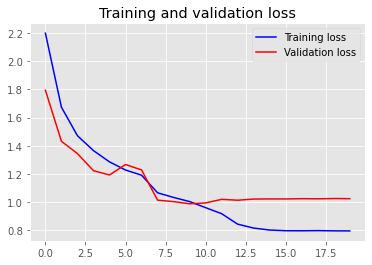

In [32]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Extract and visualize embedding

In [33]:
intermediate_layer_model = tf.keras.Model(inputs=final_model.input,
                                       outputs=final_model.layers[-1].output)
intermediate_output = intermediate_layer_model([image_train[:10000], text_train[:10000]])

y_train = np.argmax(label_train, axis = 1)
tsne_label = []
for i in range(10000):
    tsne_label.append(str(CATEGORIES[y_train[i]]))

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.manifold import TSNE
X = preprocessing.normalize(intermediate_output)
y = tsne_label
le = LabelEncoder()
y = le.fit_transform(y)

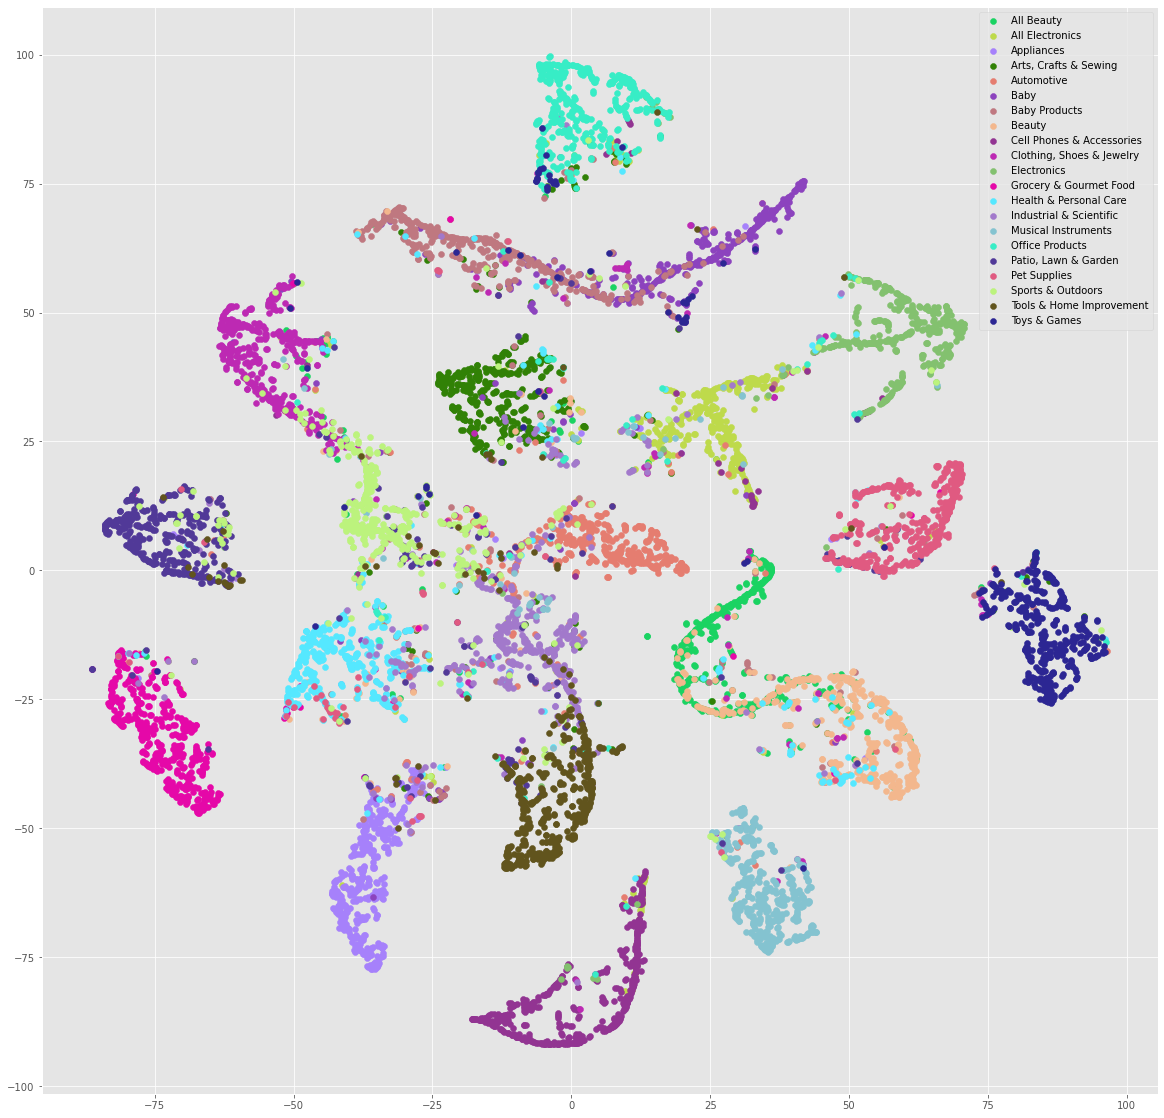

In [35]:
tsne = TSNE(n_components=2, random_state=0)
target_ids = range(len(le.classes_))

X_2d = tsne.fit_transform(X)

plt.figure(figsize=(20, 20))
for i, label in zip(target_ids, le.classes_):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=np.random.rand(3,), label=label)
plt.legend()
plt.show()

# Read the test data

In [36]:
data_test = pd.read_csv('../input/retail-products-classification/test.csv')
data_test.head(10)

,ImgId,title,description
0,B0006IK25E,Jacquard Textile Paint 2.25 Oz Pink,Jacquard Textile Pink Color in 2.25 ounces can...
1,B000GBRO16,Fimo Soft Polymer Clay 2 Ounces-8020-33 Brilli...,Fimo Soft Polymer Clay is easier to use than b...
2,B000H6OZGW,Sculpey III 2 Oz. Polymer Clay: Pale Pistachio,Sculpey 3 Polymer Clay is America's original o...
3,B000BR28KC,Sennelier Soft Pastel Turquoise Green 724,Handmade since 1900 Sennelier extra-fine soft ...
4,B0006IK27M,Jacquard Textile Colors sapphire blue,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
5,B0000AZ6NS,"Sudbury Heavy Duty ELASTO Sealant, White, CART...","Elastomeric marine sealant. One part, fast ski..."
6,B0006IK268,Jacquard Textile Colors ruby red,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
7,B000FNDZN6,Dylon Permanent Fabric Dye -Olive,Permanent Fabric Dye will not fade or wash awa...
8,B000GBO8UG,Fimo Soft Polymer Clay 2 Ounces-8020-70 Sahara,Fimo Soft Polymer Clay is easier to use than b...
9,B0006IK2FE,Jacquard Textile Colors yellow ochre,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...


In [37]:
del image_train
del image_test
del label_train
del label_test
del text_train
del text_test
del images
del data

In [38]:
def get_token(description):
    token = list(gensim.utils.tokenize(description))
    token = [i for i in token if(len(i) > 2)]
    token = [s for s in token if s not in stop_english]
    return token

In [39]:
test_images_path = '../input/retail-products-classification/test/test'
def create_test_data(img):
    image = load_img(os.path.join(test_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

In [40]:
test_image_ids = []
test_corpus = []
test_images = []
files = os.listdir(test_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_test_data(img)
    if img_array is not None:
        try:
            index = data_test[data_test['ImgId']==img_id].index.values[0]
            row = data_test.iloc[index , :]
            description = row[2]
            title = row[1]
            test_images.append(img_array.astype('float32'))
            test_corpus.append(get_token(str(title) + ' ' + str(description)))
            test_image_ids.append(img_id)
        except IndexError as error:
            print(error)

#tokenizer_obj=Tokenizer()
#tokenizer_obj.fit_on_texts(corpus)
#sequences=tokenizer_obj.texts_to_sequences(corpus)
#tokenizer_obj=Tokenizer()
sequences=tokenizer_obj.texts_to_sequences(test_corpus)
test_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')
test_images = np.asarray(test_images)
test_images = preprocess_input(test_images)

# **Make predictions on test data**

In [41]:
pred = final_model.predict([test_images, test_pad],batch_size=1,verbose = 2)
test_classes = np.argmax(pred, axis = 1)

6367/6367 - 141s


# Create submission file

In [42]:
import csv
with open('submission.csv', mode='w') as metadata_file:
    metadata_writer = csv.writer(metadata_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    metadata_writer.writerow(['ImgId', 'category'])
    for i, val in enumerate(test_classes):
        metadata_writer.writerow([test_image_ids[i], test_classes[i]])